# Efficient Multi Sequence Decoding with Hugging Face Transformers

This notebook demonstrates how to use an optimized decoding algorithm for text generation with Hugging Face Transformers. It leverages the `position_ids` and `attention_mask` arguments to the transformer's forward method to simultaneously and efficiently generate the next token for multiple independent sequences from a single shared KV cache.

## Introduction

branch search is a popular decoding algorithm for text generation that explores multiple candidate sequences (branchs) to find the most likely output. However, traditional branch search can be computationally expensive, especially when generating long sequences or using a large number of beams.

This notebook presents an optimized decoding algorithm that improves efficiency by processing multiple generative sequences simultaneously.  It does this by using the position_ids and attention_mask arguments to simultaneously predict the next token for all branches.  This is more efficient because the context sequence (prior to the branching) is only loaded once and is share amoungst all branchs. It is faster because multiple tokens are generated on each forward pass of the model.

The algorithm is implemented in the `mdecode` function, which takes a pre-trained language model, a steering function, input token IDs, the number of generative sequences, and the number of tokens to add as input.

The `steer` function guides the branch search by selecting tokens based on their probabilities. It can be customized to implement different token selection strategies or to incorporate external knowledge.

## Usage

This notebook provides a sample usage of the `mdecode` function with the "meta-llama/Llama-3.2-1B" model. You can easily adapt it to use other pre-trained models by changing the `model_name` variable.

## Key Features

- **Efficiency:** The `mdecode` function optimizes beam search by processing multiple branchs simultaneously and using caching to avoid redundant computations.
- **Flexibility:** The `steer` function allows for customization of the token selection process and can be adapted to different use cases.
- **Hugging Face Integration:** The notebook utilizes the Hugging Face Transformers library, making it easy to use with a wide range of pre-trained language models.

## Conclusion

This notebook provides a practical example of how to implement an optimized multi sequence decoding algorithm for text generation with Hugging Face Transformers. The presented algorithm improves efficiency and flexibility, making it suitable for various text generation tasks.


In [19]:
import copy
import time
from transformers import AutoTokenizer, AutoModelForCausalLM,AutoConfig
import torch
import transformers
import torch.nn.functional as F
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

Use a colab secret to store the hugging face token. This is required for some models, such as the llama model.

In [20]:
# Log in to Hugging Face

from huggingface_hub import login
try:
    from google.colab import userdata
    hf_token=userdata.get('huggingface')
except:
    import os
    import dotenv
    dotenv.load_dotenv("../.env")
    hf_token=os.getenv('HUGGINGFACE')


login(token=hf_token)

This is the core of the efficient multi-completion decode text generation.

In [21]:

def mdecode(model=None,steer=None, input_ids=None, n_branch=1,tokens_to_add=10,times=None):
    """
    An optimized multi decoding algorithm for text generation.

    Args:
        model: The pre-trained language model.
        steer: A function that guides the text generation by selecting tokens.
        input_ids: The input token IDs.
        n_branch: The number of sequences to generate.
        tokens_to_add: The number of tokens to add to each branch.

    Returns:
        A list of lists, where each sublist contains the generated token IDs for a branch.
    """
    entry_time=time.time()
    assert model is not None,'Model is required argument'
    if steer is None:
        # default steer is just a greedy
        def __steer(branchs,logits,output):
            next_token_probs = F.softmax(logits / 0.7, dim=-1)
            tokens = torch.argmax(next_token_probs,dim=-1)
            return tokens
        steer = __steer

    batchsize,context_len=input_ids.shape
    # Each branch is a list of token positions
    branchs = [[[] for _ in range(n_branch)] for _ in range(batchsize)]
    pkv=None
    position_ids=torch.full((batchsize,n_branch),fill_value=context_len+1,dtype=torch.int).to(model.device)

    part1=torch.full((batchsize,1,n_branch,context_len+n_branch*tokens_to_add),fill_value=float('-inf')).to(model.device)
    part2=torch.where(torch.eye(n_branch) == 1, torch.tensor(0.0), torch.tensor(float('-inf')))\
            .unsqueeze(0).unsqueeze(0).expand(batchsize, 1, -1, -1).repeat(1, 1, 1, tokens_to_add).to(model.device)
    full_mask=torch.cat([part1,part2],dim=-1)

    for n in range(tokens_to_add):
        _,seq_len=input_ids.shape
        with torch.no_grad():
            if n==0: # For the first token, run the model on the context
                output=model.forward(input_ids=input_ids, past_key_values=pkv, use_cache=True)
                logits=output.logits[:,-1:,:].expand(-1,n_branch,-1)
                pkv = output.past_key_values
            else: # For subsequent tokens, use the cache and attention mask

                # position_ids=torch.full((batchsize,n_branch),fill_value=contnxtt_len+n).to(model.device)

                mask=torch.full((batchsize,1,n_branch,seq_len),fill_value=float('-inf')).to(model.device)
                mask[:,:,:,:context_len]=float(0)  # Allow attention to context
                for idx in range(batchsize):
                    for branch in range(n_branch):
                        for pos in range(n):
                            mask[idx,:,branch,context_len+branchs[idx][branch][pos]]=float(0.0)
                #mask = full_mask[:,:,:,:seq_len]

                output=model.forward(input_ids=input_ids[:,-n_branch:],position_ids=position_ids,attention_mask=mask, past_key_values=pkv, use_cache=True)
                logits=output.logits  # Get logits for the next token
                pkv = output.past_key_values   # Update past key/values
                position_ids+=1
            if times is not None:
              times.append(time.time()-entry_time)

            # external function to select tokens and steer the branches
            tokens=steer(branchs,logits,output)

            # #greedy
            # next_token_probs = F.softmax(output.logits / 0.7, dim=-1)
            # tokens = torch.argmax(next_token_probs,dim=-1)


            # add the selected tokens to the sequence
            input_ids = torch.cat([input_ids,tokens], dim=-1)

            # record location of branch
            for idx in range(batchsize):
                for branch in range(n_branch):
                    branchs[idx][branch].append(n*n_branch+branch)

    # Extract the generated branch ID
    branch_ids=[]
    for idx in range(batchsize):
        branch_ids.append([])
        for branch in range(n_branch):
            ids=input_ids[idx,torch.tensor(branchs[idx][branch])+context_len].to('cpu')
            branch_ids[idx].append(ids)

    return branch_ids

At each token generation step, each of the branchs needs to select the next token.  Selecting the next token is the responsibilty of the 'steer' function.
Every call to mdecode will use the same number of branch for each of the sequences in the batch.  Note that the steer function can modify the branchs list of list of lists (batch_idx, branch_idx, position_ids).  The branchs list can be modified insitu.
The steer function can be as simple as a function (i.e. sample_steer)
 can be modified to use different algorithms for selecting the tokens and for managing the branchs.  

In [22]:
# This is an example of a class implementation that implements a steering function
# A class that implements the __call__ method can act like a function that carries state.
#

class BeamSteer:
  def __init__(self,batch_size,num_beams=1,k=2):
    self.batch_size=batch_size
    self.num_beams=num_beams
    self.k=k # branching factor
    self.scores=torch.zeros((batch_size,num_beams)).to('cuda') # Beam scores
    self.temperature=0.7
    self.idx=0

  def __call__(self,beams,logits,output,greedy=None):
    next_token_probs = F.log_softmax(logits / self.temperature, dim=-1)

    if self.idx==0:
      # handle first branch by using the top probs from the first beam
      top_probs,top_tokens = torch.topk(next_token_probs[:,0],k=self.num_beams,dim=-1)
      self.scores=top_probs
      tokens=top_tokens
    else:
      top_probs,top_tokens = torch.topk(next_token_probs,k=self.k,dim=-1)

      v=self.scores.unsqueeze(-1).expand(-1,-1,self.k)+top_probs

      # select the correct beams
      vf=v.view(self.batch_size,-1)
      top_scores,top_indices=torch.topk(vf,k=self.num_beams,dim=-1)
      x=top_indices//self.k
      y=top_indices%self.k


      # use the top_scores to select which beams to continue
      # select the token for every beam
      #tokens = torch.argmax(next_token_probs,dim=-1) #replace this
      tokens = top_tokens[:,:,0]
      # update scores
      self.scores=v[:,:,0]
      #print(f"{self.scores=}")

    self.idx+=1
    return tokens


In [23]:
# this is a sample steering function
# This function will select tokens for each branch.
# it can also modify the branchs insitu

def sample_steer(branchs,logits,output,temperature=0.7,greedy=False):
    """
    Steers the branch search by selecting tokens based on their probabilities.

    This function is called by the `mdecode` function to guide the branch search process.
    It takes the current branchs, the logits from the language model, and optional
    parameters for temperature scaling and greedy selection.

    Args:
        branchs: A list of lists, where each sublist represents a branch and contains
            the token positions in the branch.
        logits: The logits from the language model, representing the unnormalized
            probabilities of the next token.
        output: The output from the language model, containing additional information
            such as past key/values.
        temperature (float, optional): The temperature used for scaling the logits
            before applying softmax. A higher temperature leads to more diverse
            token selections. Defaults to 0.7.
        greedy (bool, optional): Whether to select the token with the highest
            probability (greedy selection) or sample from the probability
            distribution. Defaults to False.

    Returns:
        torch.Tensor: A tensor containing the selected tokens for each branch.
    """
    # Apply temperature scaling to the logits
    next_token_probs = F.softmax(logits / temperature, dim=-1)

    # 3. Sample from the probability distribution:

    if greedy:
        tokens = torch.argmax(next_token_probs,dim=-1)
    else:
        # flatten then re-expand probabilities so we can us multinomial.
        tokens = torch.multinomial(next_token_probs.view(-1,next_token_probs.size(-1)), num_samples=1)
        tokens = tokens.view(next_token_probs.size(0),next_token_probs.size(1))

    return tokens

A sample usage of the mdecode function.

In [24]:
model_name="meta-llama/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name,padding_side='left')

model = AutoModelForCausalLM.from_pretrained(model_name)#,attn_implementation="flex_attention")
model = model.to("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available

In [25]:
tokenizer.pad_token = tokenizer.eos_token

prompts=["Once upon a time,","There was a"]

prompt_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)['input_ids'].to(model.device)

n_branch=10

steering=BeamSteer(batch_size=len(prompts),num_beams=n_branch,k=4)

# generate the branchs
branch_ids = mdecode(model,steering,prompt_ids,n_branch=n_branch)

# output branches with prompts
for sidx,sample_branchs in enumerate(branch_ids):
    for bidx,branch in enumerate(sample_branchs):
        ids=torch.cat([prompt_ids[sidx].cpu(),branch.cpu()])
        print(f"{sidx}.{bidx}: {''.join(tokenizer.batch_decode(ids, skip_special_tokens=True))}")

0.0: Once upon a time, there was a man who was very rich. He
0.1: Once upon a time, I was a very happy girl. I had a
0.2: Once upon a time, a young man named John was born in a small
0.3: Once upon a time, the only way to get a good night’s sleep
0.4: Once upon a time, in a land far, far away, there was
0.5: Once upon a time, when I was a kid, I used to love
0.6: Once upon a time, we were a family of four. We were a
0.7: Once upon a time, it was possible to get a good night’s sleep
0.8: Once upon a time, you could get a good night’s sleep in a
0.9: Once upon a time, before the internet, before the world wide web,
1.0: There was a time when the only way to get a good night
1.1: There was a lot of talk about the new iPhone 6s
1.2: There was a great deal of interest in the recent article by Dr
1.3: There was a bit of a delay in getting this post up,
1.4: There was a problem with your submission. Please try again later.


1.5: There was a big change in the way we do things at the
1.6: Ther

The following some utility routines to help us compare the performance of the mdecode to a naive implementation.

In [26]:
def naive_decode(model=None,steer=None, input_ids=None, n_branch=1,tokens_to_add=10,times=None):
  """
  An naive multi decoding algorithm for text generation.
  This implementation just repeats each sequence once for every parallel completion.
  increasing the batch size by *n_branch
  """
  assert model is not None,"Model is required"
  assert input_ids is not None,"Input_ids argument is required"
  batchsize,context_len=input_ids.shape

  input_ids=input_ids.repeat_interleave(n_branch,dim=0)

  # preload pkv
  pkv=None
  pos=0

  entry_time=time.time()
  for n in range(tokens_to_add):
      _,seq_len=input_ids.shape

      with torch.no_grad():
        output=model.forward(input_ids=input_ids[:,pos:], past_key_values=pkv, use_cache=True)
        pkv=output.past_key_values
        next_token_probs = F.softmax(output.logits / 0.7, dim=-1)
        tokens = torch.argmax(next_token_probs,dim=-1)
        # add the selected tokens to the sequence

        input_ids = torch.cat([input_ids,tokens[:,-1:]], dim=-1)
        pos=-1

        tmp=input_ids[0,context_len-1].to('cpu')
        if times is not None:
          times.append(time.time()-entry_time)

# define a sweep of context_len,gen_len,num_branchs
def sweeper():
  for gen_len in [5,10,50,100,150,200]:
    for context_len in [1,2,8,128,512,1024,1536,2048]:
      for num_branchs in [2,4,8,12,16,20,24,32]:
        yield context_len,num_branchs,gen_len



# collect averaged timing on some number of runs
def eval_generation(tokenizer,model,sweep,gen_call,prompt_ids,num_avg=10):
  data=[]

  reordered=defaultdict(list)
  for c,b,g in sweep:
    reordered[(c,b)].append(g)

  for (context_len,n_branch),gen_lens in reordered.items():
    times=[]
    gen_len=max(gen_lens)
    gen_times=[]
    rag=torch.full((prompt_ids.size(0),context_len),fill_value=tokenizer.eos_token_id).to(model.device)
    for _ in range(num_avg):
      tinput_ids = torch.cat([rag,prompt_ids],dim=1)
      torch.cuda.empty_cache()
      try:
        gen_time=[]
        t0=time.time()
        branch_ids = gen_call(model=model,input_ids=tinput_ids,n_branch=n_branch,tokens_to_add=gen_len,times=gen_time)
        t1=time.time()
        times.append(t1-t0)
        gen_times.append(gen_time)

      except torch.OutOfMemoryError as e:
        break # it will fail every time so stop trying

    gen_times=torch.tensor(gen_times)
    if len(gen_times.shape)==1:
      gen_times=gen_times.unsqueeze(0)
    gen_times=gen_times.mean(dim=0)+ -0.000001 #epsilon

    for gen in gen_lens:
      gen_time=float(gen_times[gen-1]) if gen<=len(gen_times) else 0.0
      data.append((context_len,n_branch,gen,gen_time))

      #data.append((context_len,n_branch,gen_len,sum(times)/len(times) if len(times)>0 else -0.001))

  return pd.DataFrame(data, columns=["context_len", "num_branchs", "gen_len", "time"])

def compare_to(sweep=None,prompt_ids=None,sequential=True,mb=True,runs=3,other=naive_decode):

  if sweep is None:
    sweep=sweeper

  sweeps=list(sweep) # need to use iterator twice, so just convert to a list

  df_mdecode=eval_generation(tokenizer,model=model,sweep=sweeps,gen_call=mdecode,prompt_ids=prompt_ids,num_avg=runs)

  if sequential:
    # for modeling sequential branchs we assume that branchss
    # are handled by sequential runs, so we just multiply a single run time the num_branchs
    # first do the single runs
    seq_sweep=set([(c,1,g)for c,b,g in sweeps])
    df_single=eval_generation(tokenizer,model=model,sweep=seq_sweep,gen_call=other,prompt_ids=prompt_ids,num_avg=runs)
    single_runs = {(row["context_len"], row["gen_len"]): row["time"] for index, row in df_single.iterrows()}

    # now construct the df_seq
    data=[]
    for c,b,g in sweeps:
      data.append((c,b,g,single_runs[(c,g)]*b))
    df_seq=pd.DataFrame(data, columns=["context_len", "num_branchs", "gen_len", "time"])


    df_comp= pd.merge(
        df_mdecode.rename(columns={'time': 'mdecode'}),
        df_seq.rename(columns={'time': 'seq'}),
        on=['context_len', 'num_branchs', 'gen_len'])
    df_comp['speedup']=df_comp['seq']/df_comp['mdecode']
  else:
    df_comp=df_mdecode.rename(columns={'time': 'mdecode'})

  if mb:
    df_mb=eval_generation(tokenizer,model=model,sweep=sweeps,gen_call=other,prompt_ids=prompt_ids,num_avg=runs)
    df_comp = pd.merge(
        df_comp,
        df_mb.rename(columns={'time': 'mb'}),
        on=['context_len', 'num_branchs', 'gen_len'])
    df_comp['speedup_mb']=df_comp['mb']/df_comp['mdecode']

  return df_comp



In [27]:
def plot_time(df,x,by=None,subtitle=""):

  ax = plt.gca() # Get the current axes

  for name in ['mdecode','seq','mb']:
    if name in df.columns:
      if by:
        for name, group in df.groupby(by):
            ax.plot(group[x], name, marker='o', linestyle='-', label=name)
      else:
        ax.plot(df[x], df[name], marker='o', linestyle='-', label=name)

  plt.xlabel(x)
  plt.ylabel("Execution Time")
  plt.title(f'{x} vs execution time'+(" Grouped by {by}" if by else ""))
  plt.legend(title='by')
  plt.grid(True)
  plt.show()

def plot_speedup(df,x,by=None,subtitle=""):

  ax = plt.gca() # Get the current axes

  for name in ['speedup','speedup_mb']:
    if name in df.columns:
      if by:
        for name, group in df.groupby(by):
            ax.plot(group[x], name, marker='o', linestyle='-', label=name)
      else:
        ax.plot(df[x], df[name], marker='o', linestyle='-', label=name)

  plt.xlabel(x)
  plt.ylabel("Speedup")
  plt.title(f'{x} vs speedup'+(" Grouped by {by}" if by else ""))
  plt.legend(title='by')
  plt.grid(True)
  plt.show()

In [28]:
tsweep=[(0,1,2),(0,1,20),(0,10,2),(0,10,20),(1000,10,10)]
single_prompt_id=prompt_ids[:1]
df=compare_to(sweep=tsweep,prompt_ids=single_prompt_id,sequential=True,runs=5)
pd.set_option('display.width', 200)
print(df)

   context_len  num_branchs  gen_len   mdecode       seq   speedup        mb  speedup_mb
0            0            1        2  0.039620  0.038020  0.959620  0.038578    0.973708
1            0            1       20  0.407117  0.372931  0.916029  0.372234    0.914317
2            0           10        2  0.040504  0.380199  9.386750  0.041046    1.013394
3            0           10       20  0.465266  3.729307  8.015428  0.402170    0.864388
4         1000           10       10  0.360160  3.379511  9.383352  1.628626    4.521947


In [29]:
def sweeper_2():
    for num_branchs in [1,2,5,7,10,12,15,20,25,30,50,75,100]:
      for context_len in [1000]:
        for num_gen in [2]:
          yield context_len,num_branchs,num_gen
df_2=compare_to(sweep=sweeper_2(),prompt_ids=single_prompt_id,sequential=True,runs=2)
print(df_2)

    context_len  num_branchs  gen_len   mdecode        seq    speedup        mb  speedup_mb
0          1000            1        2  0.181670   0.182450   1.004295  0.182024    1.001949
1          1000            2        2  0.180787   0.364900   2.018400  0.320928    1.775176
2          1000            5        2  0.180895   0.912249   5.042967  0.746595    4.127218
3          1000            7        2  0.181208   1.277149   7.047984  1.053591    5.814274
4          1000           10        2  0.183917   1.824499   9.920236  1.468661    7.985462
5          1000           12        2  0.182485   2.189399  11.997664  1.739157    9.530390
6          1000           15        2  0.190699   2.736748  14.351156  2.169349   11.375787
7          1000           20        2  0.181918   3.648998  20.058452  2.887443   15.872204
8          1000           25        2  0.183227   4.561247  24.893902  0.000000    0.000000
9          1000           30        2  0.184441   5.473497  29.676113  0.000000 

In [30]:
def sweeper_3():
    for num_branchs in [32]:
      for context_len in [1000]:
        for num_gen in range(2,200):
          yield context_len,num_branchs,num_gen
df_3=compare_to(sweep=sweeper_3(),prompt_ids=single_prompt_id,sequential=True,mb=True,runs=2)
print(df_3)

     context_len  num_branchs  gen_len    mdecode         seq    speedup   mb  speedup_mb
0           1000           32        2   0.188463    5.926047  31.444138  0.0         0.0
1           1000           32        3   0.211506    6.532721  30.886734  0.0         0.0
2           1000           32        4   0.234815    7.134711  30.384397  0.0         0.0
3           1000           32        5   0.258846    7.735217  29.883527  0.0         0.0
4           1000           32        6   0.283621    8.333540  29.382673  0.0         0.0
..           ...          ...      ...        ...         ...        ...  ...         ...
193         1000           32      195  16.981462  122.510391   7.214360  0.0         0.0
194         1000           32      196  17.143559  123.112396   7.181263  0.0         0.0
195         1000           32      197  17.298487  123.712151   7.151617  0.0         0.0
196         1000           32      198  17.455252  124.319992   7.122211  0.0         0.0
197       

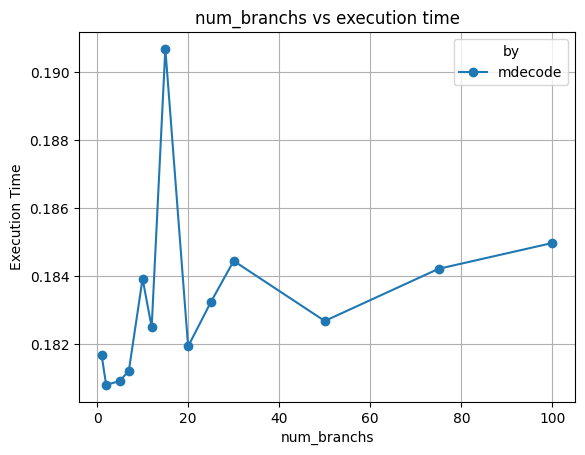

In [31]:
plot_time(df_2.drop(['seq','mb'],axis=1),"num_branchs")

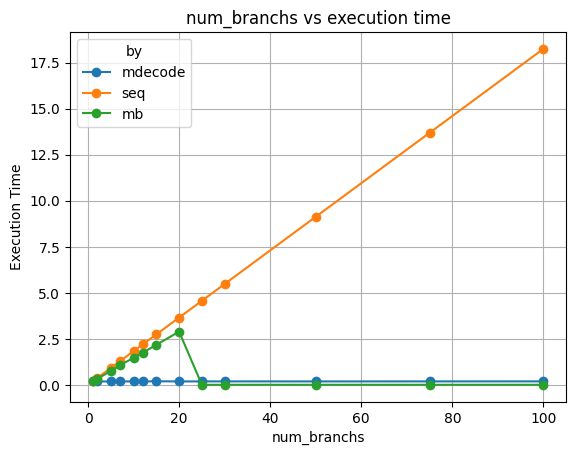

In [32]:
plot_time(df_2,"num_branchs")

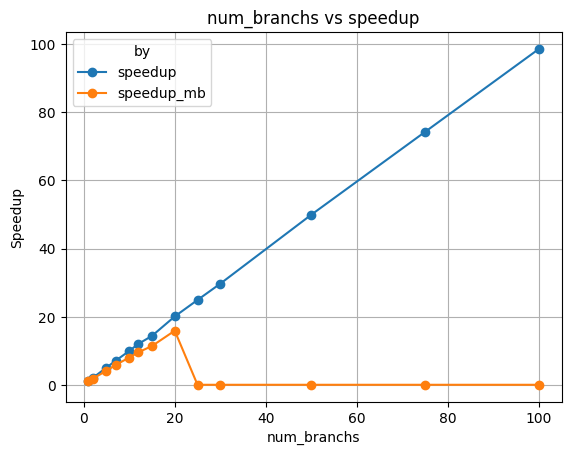

In [33]:
plot_speedup(df_2,"num_branchs")

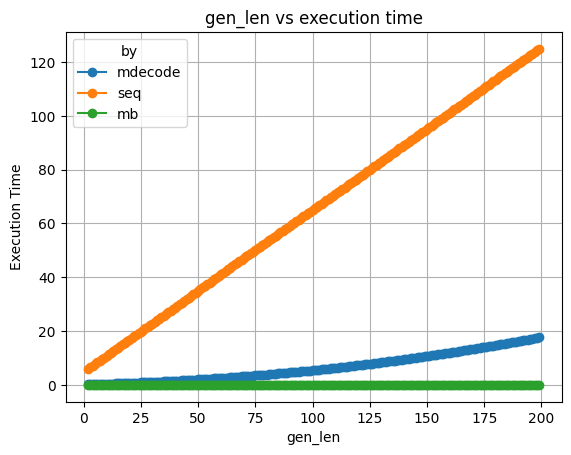

In [34]:
plot_time(df_3,"gen_len")

In [35]:
def sweeper_4():
    for num_branchs in [15]:
      for context_len in [500]:
        for num_gen in range(2,200):
          yield context_len,num_branchs,num_gen
df_4=compare_to(sweep=sweeper_4(),prompt_ids=single_prompt_id,sequential=True,mb=True,runs=2)
print(df_4)

     context_len  num_branchs  gen_len    mdecode        seq    speedup        mb  speedup_mb
0            500           15        2   0.107558   1.634478  15.196223  1.100227   10.229129
1            500           15        3   0.128795   1.964362  15.251835  1.119925    8.695397
2            500           15        4   0.150952   2.287237  15.152088  1.139599    7.549419
3            500           15        5   0.173354   2.603815  15.020259  1.159129    6.686505
4            500           15        6   0.196039   2.886530  14.724271  1.178650    6.012325
..           ...          ...      ...        ...        ...        ...       ...         ...
193          500           15      195   9.776065  56.394053   5.768584  4.931932    0.504491
194          500           15      196   9.854712  56.713328   5.754946  4.951518    0.502452
195          500           15      197   9.934045  57.031710   5.741036  4.971063    0.500407
196          500           15      198  10.012801  57.323170

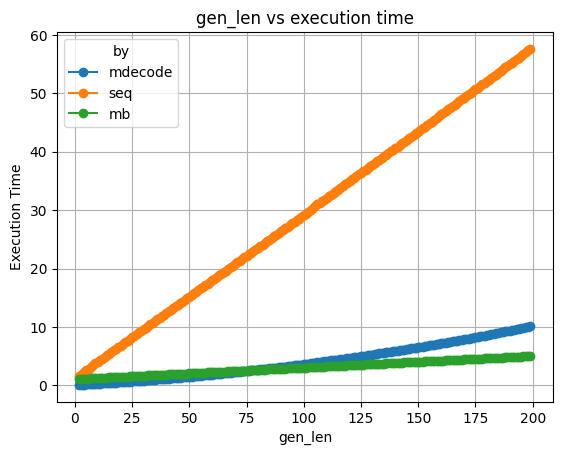

In [36]:
plot_time(df_4,"gen_len")